In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import turicreate as tc

In [2]:

data = pd.read_csv("~/Documents/UPGRAD/Recommendation System/BeerMart/beer_data.csv")
#Checking for duplicates
print(sum(data.duplicated()))
data = data.drop_duplicates()

print(data.describe())
# averaage rating = 3.8

580
         beer_beerid  review_overall
count  475404.000000   475404.000000
mean    21663.213797        3.814463
std     21794.755619        0.720518
min         3.000000        0.000000
25%      1716.000000        3.500000
50%     13896.000000        4.000000
75%     39397.250000        4.500000
max     77317.000000        5.000000


In [3]:
data.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


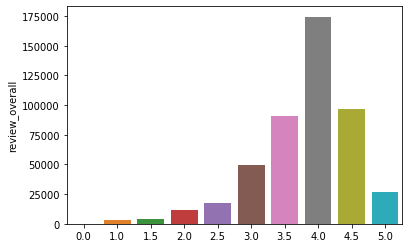

In [4]:
### How are ratings distributed?
sns.barplot(x=data.review_overall.value_counts().index, y=data.review_overall.value_counts())

                    review_overall  Total Ratings
review_profilename                               
0110x011                  4.285714             35
01Ryan10                  5.000000              1
03SVTCobra                1.000000              1
04101Brewer               4.000000              1
05Harley                  4.158537             41


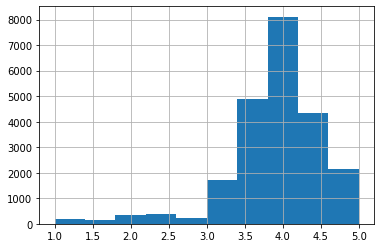

In [5]:
### Distribution of Average rating by user?
# Average ratings for each user
grpBy_User = pd.DataFrame(data.groupby('review_profilename')['review_overall'].mean())
# Total Number Of Rating  for each beer
grpBy_User['Total Ratings'] = pd.DataFrame(data.groupby('review_profilename')['review_overall'].count())
print(grpBy_User.head())
grpBy_User['review_overall'].hist(bins=10)

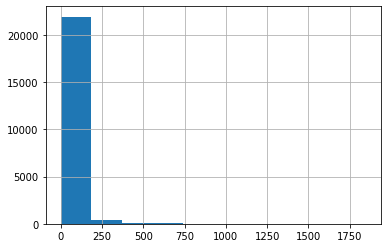

In [6]:

### Distribution of average number of rating given by a user?
grpBy_User['Total Ratings'].hist(bins=10)

             review_overall  Total Ratings
beer_beerid                               
3                  4.250000              2
4                  3.666667              6
5                  3.553097            113
6                  3.711462            253
7                  3.317961            206


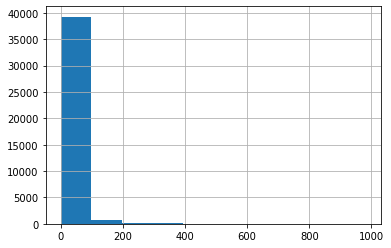

In [7]:
### Distribution of number of rating given to a beer?
# Average ratings for each beer
grpBy_beer = pd.DataFrame(data.groupby('beer_beerid')['review_overall'].mean())
# Total Number Of Rating  for each beer
grpBy_beer['Total Ratings'] = pd.DataFrame(data.groupby('beer_beerid')['review_overall'].count())
print(grpBy_beer.head())
grpBy_beer['Total Ratings'].hist(bins=10)

 We will only use beers which atleast have more than 100 rating count. Let's check how much beers we would be convering.

In [8]:
print('Coverage:',len(grpBy_beer[(grpBy_beer['Total Ratings']>=100)])/len(grpBy_beer)*100,'%')

Coverage: 2.53051503423638 %


There are 2.53% of beers which have more than 100 ratings and we would be only interested in them. Recommender systems suffer with the problem of cold start and 100 is a good number to give appropriate recommendation. Let's filter our data for only these beers.

In [9]:
beer_of_interest = grpBy_beer[(grpBy_beer['Total Ratings']>=100)].reset_index()
beer_of_interest.head()

,beer_beerid,review_overall,Total Ratings
0,5,3.553097,113
1,6,3.711462,253
2,7,3.317961,206
3,10,3.883028,218
4,17,3.429752,242


Filter data based on above 100 ratings

In [10]:
filter_data = data[data.beer_beerid.isin(beer_of_interest.beer_beerid)]
print('Data Lost:', 100-len(filter_data)/len(data)*100, '%')
filter_data.head()

Data Lost: 53.095051787532284 %


,beer_beerid,review_profilename,review_overall
12,436,Brent,3.0
101,10784,CHILLINDYLAN,4.5
102,10784,JayQue,4.0
103,10784,AlCaponeJunior,4.0
104,10784,BEERchitect,4.0


Similarly filter users who have rated more than 10 ratings

In [11]:
user_of_interest = grpBy_User[(grpBy_User['Total Ratings']>10)].reset_index()
user_of_interest.head()

,review_profilename,review_overall,Total Ratings
0,0110x011,4.285714,35
1,05Harley,4.158537,41
2,0tt0,3.964286,14
3,100floods,4.022727,44
4,1099,3.794118,17


Filter data based on above 10 ratings

In [12]:
filter_data = filter_data[filter_data.review_profilename.isin(user_of_interest.review_profilename)]
print('Data Lost:', 100-len(filter_data)/len(data)*100, '%')
filter_data.head()

Data Lost: 58.697655047075756 %


,beer_beerid,review_profilename,review_overall
12,436,Brent,3.0
101,10784,CHILLINDYLAN,4.5
102,10784,JayQue,4.0
103,10784,AlCaponeJunior,4.0
104,10784,BEERchitect,4.0


In [13]:
filter_data.isna().sum()

beer_beerid           0
review_profilename    0
review_overall        0
dtype: int64

# Rating Sparse Dataframe

In [29]:
user_rating = filter_data.pivot_table(index='review_profilename', columns='beer_beerid', values='review_overall')
user_rating= user_rating.fillna(0)
print(user_rating.shape)
user_rating.head()

(5714, 1020)


beer_beerid,5,6,7,10,17,19,30,31,33,34,...,63989,64089,64228,67044,67106,67219,68960,69363,72138,74986
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Similarity between first 10 users

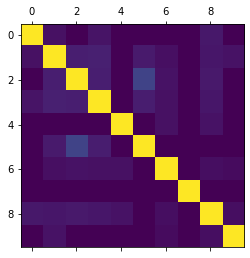

In [31]:
plt.matshow(cosine_similarity(user_rating.head(10)))
plt.show()

Similarity between first 10 beers

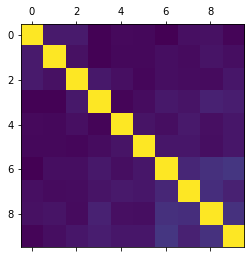

In [32]:
user_rating_T = user_rating.iloc[:,0:10].T
plt.matshow(cosine_similarity(user_rating_T))
plt.show()


In [47]:
user_rating.tail()

beer_beerid,5,6,7,10,17,19,30,31,33,34,...,63989,64089,64228,67044,67106,67219,68960,69363,72138,74986
review_profilename,,,,,,,,,,,,,,,,,,,,,
zrab11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ztaylor1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuffenhausen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuggy9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zymurgy4all,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
actions = tc.SFrame(filter_data)
training_data, validation_data = tc.recommender.util.random_split_by_user(actions, 'review_profilename', 'beer_beerid')
model = tc.recommender.create(training_data, 'review_profilename', 'beer_beerid', target='review_overall')


Preparing data set.

Data has 189436 observations with 5713 users and 1020 items.

Data prepared in: 0.253073s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 23679 / 189436 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.700662                                 |

| 5       | 0.0488281         | 0.700707                                 |

| 6       | 0.0244141         | 0.710405                                 |

| 7       | 0.012207          | 0.729378                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.700662                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 113us        | 0.902722          | 0.678513              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 250.708ms    | 0.836669          | 0.708697              | 0.0976562   |

| 2       | 514.132ms    | 0.798527          | 0.684081              | 0.0580668   |

| 3       | 782.576ms    | 0.774809          | 0.669099              | 0.042841    |

| 4       | 984.678ms    | 0.762369          | 0.66042               | 0.0345267   |

| 5       | 1.29s        | 0.751827          | 0.65209               | 0.029206    |

| 10      | 2.28s        | 0.672662          | 0.593038              | 0.017366    |

| 25      | 5.23s        | 0.522339          | 0.46842               | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.51079

Final training RMSE: 0.445737

Making recommendations for all users


In [57]:
results = model.recommend()
results

recommendations finished on 1000/5713 queries. users per second: 48742.4

recommendations finished on 2000/5713 queries. users per second: 49222.3

recommendations finished on 3000/5713 queries. users per second: 46615

recommendations finished on 4000/5713 queries. users per second: 48096

recommendations finished on 5000/5713 queries. users per second: 46082.1

review_profilename,beer_beerid,score,rank
Brent,727,5.267679383268218,1
Brent,141,5.055699398031097,2
Brent,1010,4.821624805440765,3
Brent,15813,4.6979002256296685,4
Brent,54904,4.641127039899688,5
Brent,92,4.579319705476623,6
Brent,38394,4.501423825731139,7
Brent,1577,4.458369483461242,8
Brent,1180,4.409208108892303,9
Brent,34483,4.390814949979644,10


Making recommendations for specific users

In [58]:
recommendations = model.recommend(users=['0110x011'])
print(recommendations)

+--------------------+-------------+--------------------+------+
| review_profilename | beer_beerid |       score        | rank |
+--------------------+-------------+--------------------+------+
|      0110x011      |    29619    | 5.100538824906211  |  1   |
|      0110x011      |    21690    | 5.043399189820152  |  2   |
|      0110x011      |     7971    | 4.906917904724937  |  3   |
|      0110x011      |    32286    | 4.8671835411690285 |  4   |
|      0110x011      |     9474    | 4.824432586541038  |  5   |
|      0110x011      |    22227    | 4.780541275849204  |  6   |
|      0110x011      |    22790    | 4.756658886780601  |  7   |
|      0110x011      |    28203    | 4.728523587097984  |  8   |
|      0110x011      |    17112    | 4.689326142182212  |  9   |
|      0110x011      |    45653    | 4.664738630165916  |  10  |
+--------------------+-------------+--------------------+------+
[10 rows x 4 columns]



Making recommendations for new users


In [59]:
recommendations = model.recommend(['Charlie'])
print(recommendations)

+--------------------+-------------+--------------------+------+
| review_profilename | beer_beerid |       score        | rank |
+--------------------+-------------+--------------------+------+
|      Charlie       |     1093    | 3.861451533844333  |  1   |
|      Charlie       |     731     | 3.841584456374507  |  2   |
|      Charlie       |     276     | 3.7960865844391396 |  3   |
|      Charlie       |      92     | 3.7851853642962983 |  4   |
|      Charlie       |     1708    | 3.783260529150825  |  5   |
|      Charlie       |      34     | 3.775033165922027  |  6   |
|      Charlie       |     1010    |  3.73880266140924  |  7   |
|      Charlie       |    11757    | 3.7348835517071297 |  8   |
|      Charlie       |     6108    | 3.7337847698830178 |  9   |
|      Charlie       |      88     | 3.729377885570388  |  10  |
+--------------------+-------------+--------------------+------+
[10 rows x 4 columns]



Evaluating the model

In [61]:
tc.recommender.util.compare_models(validation_data, [model], model_names=["model"])

PROGRESS: Evaluate model model

Precision and recall summary statistics by cutoff
+--------+----------------------+----------------------+
| cutoff |    mean_precision    |     mean_recall      |
+--------+----------------------+----------------------+
|   1    | 0.03211991434689507  | 0.004339959723763038 |
|   2    | 0.03586723768736619  | 0.012302674440969896 |
|   3    | 0.03247680228408279  | 0.017736392914334202 |
|   4    | 0.03131691648822269  | 0.021807987867693387 |
|   5    | 0.03169164882226977  | 0.028925163924103756 |
|   6    | 0.029264810849393297 | 0.03077291400666732  |
|   7    | 0.028296115019883734 |  0.0338019946856409  |
|   8    | 0.02877408993576017  | 0.038966514075503576 |
|   9    | 0.028313109683559316 | 0.042953664792088044 |
|   10   | 0.027730192719486086 | 0.04650290762089987  |
+--------+----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7817737513676978

Per User RMSE (best)
+--------------------+-------------------

[{'precision_recall_by_user': Columns:
  	review_profilename	str
  	cutoff	int
  	precision	float
  	recall	float
  	count	int
  
  Rows: 16812
  
  Data:
  +--------------------+--------+--------------------+---------------------+-------+
  | review_profilename | cutoff |     precision      |        recall       | count |
  +--------------------+--------+--------------------+---------------------+-------+
  |       JayQue       |   1    |        1.0         | 0.02631578947368421 |   38  |
  |       JayQue       |   2    |        0.5         | 0.02631578947368421 |   38  |
  |       JayQue       |   3    | 0.3333333333333333 | 0.02631578947368421 |   38  |
  |       JayQue       |   4    |        0.25        | 0.02631578947368421 |   38  |
  |       JayQue       |   5    |        0.4         | 0.05263157894736842 |   38  |
  |       JayQue       |   6    | 0.3333333333333333 | 0.05263157894736842 |   38  |
  |       JayQue       |   7    | 0.2857142857142857 | 0.05263157894736842 |   3